In [1]:
import os
import shutil

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

from sklearn import preprocessing
from transformers import AutoModel

tf.get_logger().setLevel('ERROR')



In [6]:
from transformers import AutoTokenizer, TFAutoModel
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert = TFAutoModel.from_pretrained("bert-base-cased")

2022-08-01 17:13:16.620126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 17:13:16.626605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 17:13:16.627134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 17:13:16.628242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
base_path = "../datasets/ecommerce"
df_full = pd.read_csv(f"{base_path}/sample_products.csv", header=None)

In [72]:
le = preprocessing.LabelEncoder()
df_full["target"] = le.fit_transform(df_full[0])
df_full = df_full.dropna()
# df_full

In [73]:
arr = df_full["target"].values 
labels = np.zeros((arr.size, arr.max()+1))  
labels[np.arange(arr.size), arr] = 1  

In [158]:
df_full[1][:10].values

array(['Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for etern

In [146]:
def encoder_labels(labels):
    le = preprocessing.LabelEncoder()
    arr = le.fit_transform(labels)
    labels = np.zeros((arr.size, arr.max()+1))  
    labels[np.arange(arr.size), arr] = 1  
    return labels

In [145]:
def toDataset(sequences, labels, max_seq):
    # initialize two arrays for input tensors
    Xids, Xmask = inputs_masks(sequences, max_seq)
    dataset = convert_dataset(Xids, Xmask, labels)
    return split_data(dataset)

In [122]:
def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

In [139]:
def inputs_masks(sentences, max_seq):
    Xids = np.zeros((len(sentences), max_seq))
    Xmask = np.zeros((len(sentences), max_seq))

    for i, sentence in enumerate(sentences):
        Xids[i, :], Xmask[i, :] = tokenize(sentence)
        if i % 10000 == 0:
            print(i)  
    return Xids, Xmask

In [137]:
def convert_dataset(Xids, Xmask, labels):
    BATCH_SIZE = 32  # we will use batches of 32

    # load arrays into tensorflow dataset
    dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

    # create a mapping function that we use to restructure our dataset
    def map_func(input_ids, masks, labels):
        return {'input_ids': input_ids, 'attention_mask': masks}, labels

    # using map method to apply map_func to dataset
    dataset = dataset.map(map_func)

    # shuffle data and batch it
    return dataset.shuffle(10000).batch(BATCH_SIZE)

In [ ]:
def split_data(dataset):
    # get the length of the batched dataset
    DS_LEN = len([0 for batch in dataset])
    SPLIT = 0.9  # 90-10 split

    train = dataset.take(round(DS_LEN*SPLIT))  # get first 90% of batches
    val = dataset.skip(round(DS_LEN*SPLIT))  # skip first 90% and keep final 10%

    del dataset  # optionally, delete dataset to free up disk-space
    return train, val

In [142]:
def bert_model(num_classes, max_seq=128):
    input_ids = tf.keras.layers.Input(shape=(max_seq,), name='input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(max_seq,), name='attention_mask', dtype='int32')

    # we consume the last_hidden_state tensor from bert (discarding pooled_outputs)
    embeddings = bert(input_ids, attention_mask=mask)[0]

    X = tf.keras.layers.LSTM(64)(embeddings)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dense(64, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.1)(X)
    y = tf.keras.layers.Dense(num_classes, activation='softmax', name='outputs')(X)

    # define input and output layers of our model
    model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

    # freeze the BERT layer - otherwise we will be training 100M+ parameters...
    model.layers[2].trainable = False
    
    optimizer = tf.keras.optimizers.Adam(0.01)
    loss = tf.keras.losses.CategoricalCrossentropy()  # categorical = one-hot
    acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

    model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
    
    return model

In [ ]:
sequences = df_full[1]
labels = encoder_labels(df_full[0])
SEQ_LEN = 128  

train, val = toDataset(sequences, labels, SEQ_LEN)

In [143]:
num_classes = 4
model = bert_model(num_classes)

In [129]:
history = model.fit(train, validation_data=val, epochs=4)

Epoch 1/4
1418/1418 [==============================] - 1073s 747ms/step - loss: 0.2126 - accuracy: 0.9321 - val_loss: 0.2100 - val_accuracy: 0.9317
Epoch 2/4
1418/1418 [==============================] - 1056s 744ms/step - loss: 0.2002 - accuracy: 0.9380 - val_loss: 0.1991 - val_accuracy: 0.9334
Epoch 3/4
1418/1418 [==============================] - 1083s 764ms/step - loss: 0.2314 - accuracy: 0.9300 - val_loss: 0.2640 - val_accuracy: 0.9237
Epoch 4/4
1418/1418 [==============================] - 1086s 766ms/step - loss: 0.2137 - accuracy: 0.9338 - val_loss: 0.2365 - val_accuracy: 0.9317


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


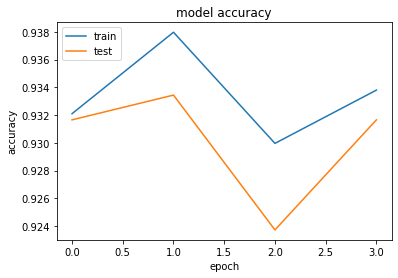

In [130]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


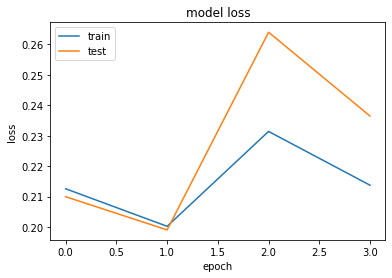

In [131]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# model.save('../models/ecommerce_hugging/')

In [132]:
model.save('../models/ecommerce_hugging/bert_model.h5')


In [ ]:
df_full[1][10:20].values

In [166]:
sequence_sample = [
    "Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal bliss.so bring home this elegant print that is lushed with rich colors that makes it nothing but sheer elegance to be to your friends and family.it would be treasured forever by whoever your lucky recipient is. Liven up your place with these intriguing paintings that are high definition hd graphic digital prints for home, office or any room", 
    "ncredible Gifts India Wooden Happy Birthday Unique Personalized Gift (5 X 4 Inch) Size:4 x 5   Made Of Natural Imported Wood, Which Is Quite Solid With Light Particle Pattern & Is Soft Pale To Blond Colour. Your Uploaded Photo Will Look Amazing And Beautiful After Laser Engraving On It. This Is One Of The Most Popular Unique Gifts In Our Store. We Offer This In Multiple Sizes, Some Can Be Used As Table Top And The Big Sizes Can Be Used As Wall Hanging Which Just Blends With Your Home Decaration. You Just Need To Upload A Picture And Add Your Own Text And We Will Do The Rest For You. We Will Email You The Preview Before Making The Final Product. Do You Want The Best Moment Of Your Life To Be Engraved On A Wooden Plaque That Lasts For A Longer Time And Stays Close To You Forever? Then You Are At The Right Place. We Present To You Various Sizes Personalized Engraved Wooden Plaques Made With Birch Wood. Let Your Memories Be Engraved On Wooden Plaques And Stay With Your Forever."
]
gt = df_full["target"][1000:2000]

Xids_sample, Xmask_sample = inputs_masks(df_full[1][1000:2000].values, 128)
predictions = model.predict([Xids_sample, Xmask_sample])
print(predictions)
np.argmax(predictions, axis=1)

0
32/32 [==============================] - 19s 599ms/step
[[0.35511237 0.17605643 0.24516374 0.2236675 ]
 [0.29650092 0.20074794 0.26077133 0.24197982]
 [0.35478744 0.23021106 0.20025714 0.21474434]
 ...
 [0.29376328 0.13241595 0.2831889  0.29063183]
 [0.33404115 0.18870142 0.24179511 0.23546232]
 [0.2932002  0.24002886 0.25675726 0.2100137 ]]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 2, 2, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0,
       3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 3, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 3, 3, 0, 0,
       3, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 3, 2, 2, 0, 0, 0, 0, 0, 0,
       2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2,

In [167]:
gt

1000    3
1001    3
1002    3
1003    3
1004    3
       ..
1995    3
1996    3
1997    3
1998    3
1999    3
Name: target, Length: 1000, dtype: int64